一個模型服務任意風格(Arbitrary-Style-Per-Model:ASPM)
=============================
作者 : 湯沂達 https://github.com/mistake0316

-------------

簡介
------------
在上一個版本的程式碼我們復現了論文 `A Learned Representation For Artistic Style<https://arxiv.org/abs/1610.07629>`。
<img src="https://i.imgur.com/VaCsSQrr.png" width="800px"/><br>
其為每個風格影像在每一層註冊了一組放大量 $\gamma$、位移量 $\beta$，如上圖所示<br>
而這次的記事本是要復現這個論文`Exploring the structure of a real-time, arbitrary neural artistic stylization network<https://arxiv.org/abs/1705.06830>`<br>
<img src="https://i.imgur.com/iEMS5Mi.png" width="800px"/><br>
要使得模型能夠服務<font size="6rem" color="pink">任意</font>的風格影像，如上圖所示。<br>
所用的方法是訓練一個<font size="6rem" color="pink">額外網路</font>來預測風格化影像對應的$\gamma$, $\beta$


## 註
1. 模型架構部分基本上都大改了，不過核心精神不變
2. 使用的權重來自於tensorflow的範例`https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2`
3. 將tensorflow的存檔轉換成pytorch能讀的存檔
  * 參考程式碼 : https://github.com/philipjackson/style-augmentation
  * 個人實作 : https://github.com/mistake0316/CLIPStyleTransfer/blob/main/utils/Convert%20Weight%20From%20tfhub%20to%20torch.ipynb


In [1]:
#@title 導入函式庫
!pip -q install torchinfo
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

import torchinfo

from tqdm.auto import tqdm
from collections import OrderedDict
import numpy as np

import copy
import re
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device:{device}")

device:cuda


In [2]:
#@title 下載影像
!rm -rf Neural-Style-Transfer
!git clone https://github.com/titu1994/Neural-Style-Transfer
!mv ./Neural-Style-Transfer/images/inputs ./images
!rm -rf Neural-Style-Transfer

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 1421, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1421 (delta 8), reused 12 (delta 4), pack-reused 1393
Receiving objects: 100% (1421/1421), 68.19 MiB | 24.00 MiB/s, done.
Resolving deltas: 100% (827/827), done.


In [3]:
content_paths = os.listdir("images/content")
content_paths

['ancient_city.jpg',
 'sagano_bamboo_forest.jpg',
 'golden_gate.jpg',
 'Aurea-Luna.jpg',
 'Dawn Sky.jpg',
 'tubingen.jpg',
 'Sunlit Mountains.jpg',
 'winter-wolf.jpg',
 'Dipping-Sun.jpg',
 'Japanese-cherry-widescreen-wallpaper-Picture-1366x768.jpg',
 'Kinkaku-ji.jpg',
 'blue-moon-lake.jpg']

In [4]:
style_paths = sorted([*filter(lambda x:x[-3:] in ["jpg", "png"], os.listdir("images/style/"))])
style_paths

['Blue Strokes.jpg',
 'bamboo_forest.jpg',
 'blue_swirls.jpg',
 'candy-style.jpg',
 'escher_sphere.jpg',
 'frida_kahlo.jpg',
 'japanese_flower_sakai_hoitsu.jpg',
 'japanese_painting.jpg',
 'misty-mood-leonid-afremov.jpg',
 'patterned_leaves.jpg',
 'picasso_selfport1907.jpg',
 'red-canna.jpg',
 'seated-nude.jpg',
 'shipwreck.jpg',
 'starry_night.jpg',
 'starry_night_crop.png',
 'the_scream.jpg',
 'water-lilies-1919-2.jpg',
 'wave_kanagawa.jpg',
 'woman-with-hat-matisse.jpg']

In [5]:
# desired size of the output image
imsize = 1024 #@param {type:"number"}

normal_transform = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()]
)
style_transform = torch.nn.Sequential(
  # style_transform如果改了會出問題，我也不知道為什麼
  transforms.Resize(256,),
  transforms.CenterCrop(256),
  torch.nn.AvgPool2d(kernel_size=3,stride=1)
)

def image_loader(image_name, mod=64):
    image = Image.open(image_name).convert("RGB")
    image = normal_transform(image)
    image = image[:,:image.shape[1]//mod*mod, :image.shape[2]//mod*mod].unsqueeze(0)
    return image.to(device, torch.float)

def style_loader(image_name, mod=64):
    image = Image.open(image_name).convert("RGB")
    image = transforms.ToTensor()(image)
    image = style_transform(image)
    image = image[:,:image.shape[1]//mod*mod, :image.shape[2]//mod*mod].unsqueeze(0)
    return image.to(device, torch.float)

content_path = "./images/content/ancient_city.jpg" #@param {type:"string"}

content_img = image_loader(content_path)

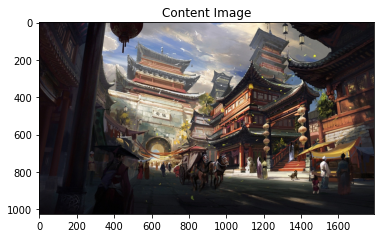

In [6]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    fig = plt.imshow(image)
    plt.title(title)
    plt.show()
    
imshow(content_img, title='Content Image')

## 風格轉換模型
我從 https://github.com/philipjackson/style-augmentation 參考後改出來的<br>
程式碼位於 https://github.com/mistake0316/CLIPStyleTransfer/tree/main/utils

### 模型定義
下方只是顯示用，沒有實際拿來執行

#### 風格向量預測模型
```python
# 原始碼位置：https://github.com/mistake0316/CLIPStyleTransfer/blob/main/utils/stylePredictor26.py#L15-L76
class StylePredictor(nn.Module):
    # 基本上就是個一般的卷積模型
    # 可以自行去看程式碼

    # 輸入是 (B,C,W,H) -> 輸出是 (B, 768, w, h)
    # 沿著像素方向計算平均值後得到  (B, 768) 的向量
    # 最後這向量會在風格轉換模型中使用
```

#### 需要用到風格向量的模組
（只舉例其一，並擷取重點）
```python
# 原始碼位置：https://github.com/mistake0316/CLIPStyleTransfer/blob/main/utils/transform26.py#L35-L71
class UpsampleConvInRelu(nn.Module):
  def __init__(self, channels_in, channels_out, kernel_size, upsample, stride=1, activation=nn.ReLU):
    super(UpsampleConvInRelu, self).__init__()
    # .....
    self.fc_beta = nn.Linear(768,channels_out)
    self.fc_gamma = nn.Linear(768,channels_out)
    # .....
    
  def forward(self, x, style):
    # x: B x C_in x H x W
    # style: B x 768
    beta = self.fc_beta(style).unsqueeze(2).unsqueeze(3) # B x C_out x 1 x 1
    gamma = self.fc_gamma(style).unsqueeze(2).unsqueeze(3) # B x C_out x 1 x 1
    # .....
    x = self.instancenorm(x)
    x = gamma * x + beta
    # .....
    return x
```

#### 風格轉換骨幹模型
```python
# 原始碼位置：https://github.com/mistake0316/CLIPStyleTransfer/blob/main/utils/transform26.py#L115-L141
class Ghiasi(nn.Module):
  def __init__(self):
    super(Ghiasi,self).__init__()
    self.layers = nn.ModuleList([
      ConvRelu(3,32,9,stride=1),
      ConvRelu(32,64,3,stride=2),
      ConvRelu(64,128,3,stride=2),
      *[ResidualBlock(128) for _ in range(20)],
      UpsampleConvInRelu(128,64,3,upsample=2),
      UpsampleConvInRelu(64,32,3,upsample=2),
      UpsampleConvInRelu(32,3,9,upsample=None,activation=None)
    ])

    self.n_params = sum([layer.n_params for layer in self.layers])

  def forward(self,x,styles):
    # x: B x 3 x H x W
    # styles: B x 100 batch of style embeddings
    
    for i, layer in enumerate(self.layers):
      if i < 3:
        # 這模型的前三層沒有使用Instance Normalization
        x = layer(x)
      else:
        x = layer(x, styles)
    
    return torch.sigmoid(x)
```

### 下載並讀取模型

In [7]:
%%bash
model_folder=weight
mkdir -p $model_folder
wget -q https://github.com/mistake0316/CLIPStyleTransfer/blob/main/utils/weight/Ghiasi26.pth?raw=true -O $model_folder/Ghiasi26.pth
wget -q https://github.com/mistake0316/CLIPStyleTransfer/blob/main/utils/weight/predictor26.pth?raw=true -O $model_folder/predictor26.pth

wget -q https://raw.githubusercontent.com/mistake0316/CLIPStyleTransfer/main/utils/stylePredictor26.py -O stylePredictor26.py
wget -q https://raw.githubusercontent.com/mistake0316/CLIPStyleTransfer/main/utils/transform26.py -O transform26.py

In [8]:
from stylePredictor26 import pretrainedStylePredictor
from transform26 import pretrainedGhiasi

In [9]:
SP = pretrainedStylePredictor().to(device).eval()
G = pretrainedGhiasi().to(device).eval()
print("model loaded")

model loaded


## 開始執行吧！

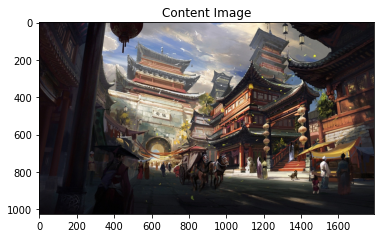

In [10]:
imshow(content_img, title='Content Image')

In [11]:
# display style images
for base_name in style_paths:
  imshow(
    image_loader(f"/content/images/style/{base_name}"),
    title=f"style_image:{base_name}"
  )

Output hidden; open in https://colab.research.google.com to view.

In [12]:
with torch.no_grad():
  for base_name in style_paths:
    file_path = f"/content/images/style/{base_name}"
    emb = SP(style_loader(file_path))
    result = G(content_img, emb)
    plt.figure(figsize = (10,10))
    imshow(result, title=f"style_result:{base_name}")

Output hidden; open in https://colab.research.google.com to view.

# 風格內差

In [13]:
# ['Blue Strokes.jpg',
#  'bamboo_forest.jpg',
#  'blue_swirls.jpg',
#  'candy-style.jpg',
#  'escher_sphere.jpg',
#  'frida_kahlo.jpg',
#  'japanese_flower_sakai_hoitsu.jpg',
#  'japanese_painting.jpg',
#  'misty-mood-leonid-afremov.jpg',
#  'patterned_leaves.jpg',
#  'picasso_selfport1907.jpg',
#  'red-canna.jpg',
#  'seated-nude.jpg',
#  'shipwreck.jpg',
#  'starry_night.jpg',
#  'starry_night_crop.png',
#  'the_scream.jpg',
#  'water-lilies-1919-2.jpg',
#  'wave_kanagawa.jpg',
#  'woman-with-hat-matisse.jpg']

style_1_name = "bamboo_forest.jpg"
style_2_name = "shipwreck.jpg"

style_1_path = f"/content/images/style/{style_1_name}"
style_2_path = f"/content/images/style/{style_2_name}"
with torch.no_grad():
  emb1 = SP(style_loader(style_1_path))
  emb2 = SP(style_loader(style_2_path))

n_frames = 300
outs_list = []
with torch.no_grad():
  for w in tqdm(np.linspace(0, 1, n_frames)):
    emb = (1-w)*emb1 + w*emb2
    result = G(content_img, emb)
    outs_list.append(
        result*255
    )

  0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
#影片生成
output_path = f"out_{style_1_name.split('.')[0]}_{style_2_name.split('.')[0]}.mp4"
out_video_writer = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc(*"mp4v"),
    60,
    (outs_list[0].shape[-1], outs_list[0].shape[-2])
)
for torch_tensor in tqdm(outs_list):
  out = torch_tensor.cpu().numpy()
  out = out.astype(np.uint8)
  out = np.einsum("bchw->bhwc",out)[0,...,::-1] # remove batch, rgb->bgr
  out_video_writer.write(out)
out_video_writer.release() 

  0%|          | 0/300 [00:00<?, ?it/s]

### 可以下載並觀看影片(out_X_X.mp4)

In [15]:
from IPython.display import HTML
HTML(f"""
<h1>我預先把內差結果上傳到imgur上了，這是bamboo_forest=>shipwreck的結果</h1>
<video src="https://i.imgur.com/xRm3Kis.mp4" controls autoplay width=60% loop/>
""")

# 課後
1. 試著思考比較各個演算法的好壞之處
2. 由於為了教學方便，使用了研究同一流派的方法<br>
但其實有精神相似，更早發表，且更貪心的做法，這方法的 $\gamma$, $\beta$ 甚至不用額外訓練<br>
有興趣可以去研究一下<br>
Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization<br>https://arxiv.org/abs/1703.06868
